In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import ujipenchars2
from preprocessing import DrawingToBoxScaler, DrawingResampler
from dtw import dtw_distance_matrix

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)

drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
train = drawing_scaler.transform(train)
test = drawing_scaler.transform(test)

data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([int(drawing.label) for drawing in data], dtype=np.int8)

In [3]:
drawing_resampler = DrawingResampler(50)
# Resampling s 50 točaka
resampled_data = drawing_resampler.transform(data)
# Matrica s DTW udaljenostima
D = dtw_distance_matrix(np.array([np.vstack(drawing.strokes) for drawing in resampled_data], dtype=np.float32))

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

class GridSearchGamma:
    def __init__(self, estimator, gammas, param_grid, cv=5):
        self.gammas = gammas
        self.best_score_ = 0
        self.best_index_ = 0
        self.best_gamma_ = None
        self.best_params_ = None
        self.best_estimator_ = None
        
        self.gs = [GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1, cv=cv) for gamma in gammas]

    def kernel_transform(self, X, gamma):
        return np.exp(-gamma * X)

    def fit(self, X, y):
        for i in range(len(self.gammas)):
            self.gs[i].fit(self.kernel_transform(X, self.gammas[i]), y)
            if self.gs[i].best_score_ > self.best_score_:
                self.best_index_ = i
                self.best_score_ = self.gs[i].best_score_
        self.best_gamma_ = self.gammas[self.best_index_]
        self.best_params_ = self.gs[self.best_index_].best_params_
        self.best_estimator_ = self.gs[self.best_index_].best_estimator_

    def score(self, X, y):
        return self.gs[self.best_index_].score(self.kernel_transform(X, self.best_gamma_), y)


gs = GridSearchGamma(
    estimator = SVC(kernel='precomputed'),
    gammas = np.arange(0.3, 0.7, 0.02),
    param_grid = {'C': np.arange(0.3, 0.9, 0.02)},
)

np.random.seed(0)
gs.fit(D[np.ix_(train_idx, train_idx)], labels[train_idx])

In [5]:
print('Najbolji parametri:', ', '.join(f'{k} = {v:.4g}' for k, v in ({'gamma': gs.best_gamma_} | gs.best_params_).items()))
print('Najbolja CV točnost:', gs.best_score_)
print('Točnost na test skupu:', gs.score(D[np.ix_(test_idx, train_idx)], labels[test_idx]))
print('\nBroj potpornih vektora:', len(gs.best_estimator_.support_))

Najbolji parametri: gamma = 0.52, C = 0.62
Najbolja CV točnost: 0.975
Točnost na test skupu: 0.9775

Broj potpornih vektora: 320


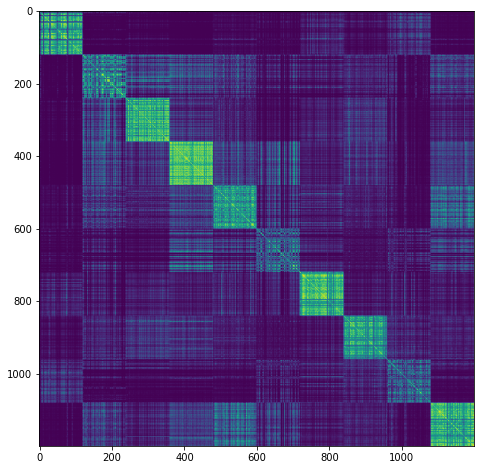

In [6]:
# Plot kernel funkcije za najbolji gamma
sorted_idx = np.argsort(labels)
plt.figure(figsize=(8, 8))
plt.imshow(gs.kernel_transform(D[np.ix_(sorted_idx, sorted_idx)], gs.best_gamma_), cmap='viridis')
plt.show()